<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/VesuviusChallenge/VesuviusChallenge_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VesuviusChallenge - Deciphering Ancient Papyrus Scrolls

## Download data

In [1]:
### Download data from kaggle, and store a segment of it in google drive

# import json
# import zipfile
# kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'vesuvius-challenge-ink-detection' --force
# # #1% 131M/20.6G [00:06<17:23, 21.1MB/s]

# with zipfile.ZipFile("/content/vesuvius-challenge-ink-detection.zip","r") as zip_ref:
#     zip_ref.extractall("kaggledata")

# !zip -r -j /content/ink1.zip /content/content/kaggledata/train/1

# # upload zip to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/ink1.zip /content/gdrive/MyDrive/AIData/vesuvius1.zip

In [2]:
## Retrieve data(zip) from google drive
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/AIData/vesuvius1.zip /content/vesuvius1.zip 

Mounted at /content/gdrive


In [3]:
import zipfile
with zipfile.ZipFile("vesuvius1.zip","r") as zip_ref:
    zip_ref.extractall("train_data")
drive.flush_and_unmount()

## Imports

In [ ]:
stop

In [10]:
import torch
import torch.nn as nn
import numpy as np
import PIL
# import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
# from ipywidgets import interact, fixed
from pathlib import Path
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

on device: cuda


## Understanding the data

In [37]:
root_filepath = '/content/train_data/'

all_files = sorted(os.listdir(root_filepath))
# ['inklabels.png', 'inklabels_rle.csv', 'ir.png', 'mask.png']
tif_filenames = all_files[:-4]
print(len(tif_filenames))

65


In [35]:
import pandas as pd
df = pd.read_csv(root_filepath+'inklabels_rle.csv')
print(len(df.Predicted[0]))
df.head()

348148


,Id,Predicted
0,1,606211 19 612538 26 618867 39 625196 44 631525...


img_original shape: (8181, 6330)
img_ink_labels shape: (8181, 6330)
img_ink_mask shape: (8181, 6330)


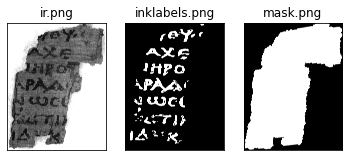

In [36]:
img_original = np.array(PIL.Image.open(root_filepath+'ir.png'))
img_ink_labels = np.array(PIL.Image.open(root_filepath+'inklabels.png'))
img_ink_mask = np.array(PIL.Image.open(root_filepath+'mask.png'))
print(f"img_original shape: {img_original.shape}")
print(f"img_ink_labels shape: {img_ink_labels.shape}")
print(f"img_ink_mask shape: {img_ink_mask.shape}")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('ir.png')
ax1.imshow(img_original, cmap = 'gray')
ax2.set_title('inklabels.png')
ax2.imshow(img_ink_labels, cmap = 'gray')
ax3.set_title('mask.png')
ax3.imshow(img_ink_mask, cmap = 'gray')
for ax in [ax1, ax2, ax3]:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[0.0, 0.69755095, 0.8771649, 0.855787]


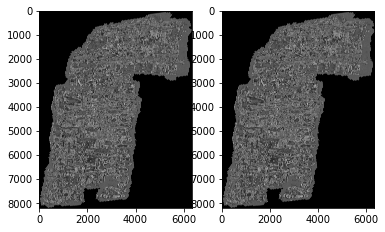

In [38]:
#Each tif file is a layer in the scan
images = []
for path in tif_filenames[:5]:
    images.append(np.array(PIL.Image.open(root_filepath+path), dtype = np.float32)/65535.0)
print([images[0][i].max() for i in range(0, 2000, 500)])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images[0], cmap = 'gray')
ax2.imshow(images[1], cmap = 'gray')
plt.show()

In [ ]:
# image_stack = torch.stack([torch.from_numpy(img) for img in images], dim = 0)
# print(image_stack.shape)

## Copied from kaggle notebook




Code taken from kaggle [notebook](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
import os

PREFIX = '/content/train_data/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32

all_files = sorted(os.listdir(PREFIX))
tif_filenames = all_files[:-4]

In [6]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)

In [7]:
images = [np.array(Image.open(PREFIX+filename), dtype=np.float32)/65535.0 for filename in tqdm(tif_filenames[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


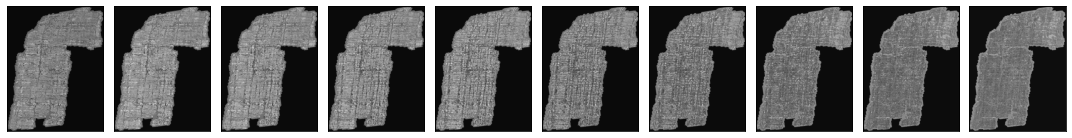

In [8]:
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

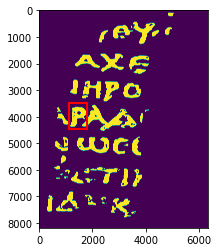

In [9]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [21]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    running_loss += loss.item()
    if i % 3000 == 3000-1:
        print("Loss:", running_loss / 3000)
        running_loss = 0.0

Generating pixel lists...
Training...


 10%|█         | 3038/30000 [00:16<02:00, 224.52it/s]

Loss: 0.4489959808935722


 20%|██        | 6041/30000 [00:29<01:44, 228.23it/s]

Loss: 0.4122526069035133


 30%|███       | 9041/30000 [00:42<01:31, 229.95it/s]

Loss: 0.40508003390332065


 40%|████      | 12027/30000 [00:55<01:19, 227.46it/s]

Loss: 0.3959455924034119


 50%|█████     | 15029/30000 [01:08<01:05, 229.78it/s]

Loss: 0.3832185340821743


 60%|██████    | 18039/30000 [01:21<00:52, 226.89it/s]

Loss: 0.371524615171055


 70%|███████   | 21042/30000 [01:34<00:38, 231.95it/s]

Loss: 0.3604966836596529


 80%|████████  | 24028/30000 [01:47<00:26, 228.02it/s]

Loss: 0.33913050702462594


 90%|█████████ | 27031/30000 [02:00<00:12, 230.16it/s]

Loss: 0.31232715978473424


100%|██████████| 30000/30000 [02:13<00:00, 224.23it/s]


Loss: 0.28207893659919503


100%|██████████| 20833/20833 [00:43<00:00, 480.81it/s]


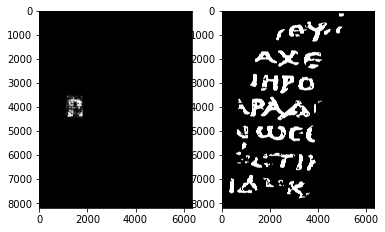

In [23]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_inside_rect[i*BATCH_SIZE+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()


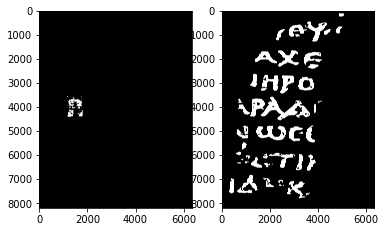

In [24]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [25]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

In [26]:
len(list(rle_output.split(' ')))

12180